### 1. Import necessary libraries

In [2]:
# Data handling and numerical computations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine learning models (Basic)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning models (Advanced)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Real-time data and deployment (for future use)
import joblib
import datetime

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

### 2. Load and prepare data

In [10]:
# Select only essential metadata columns from the station file (with correct names)
selected_station_cols = [
    'station_key',
    'suburb',
    'road_functional_hierarchy',
    'road_classification_type',
    'lane_count',
    'wgs84_latitude',
    'wgs84_longitude'
]

# Load station metadata (small file, selective columns)
station_data = pd.read_csv("../datasets_cleaned/trafficStations.csv", usecols=selected_station_cols)

# Load traffic data (large file)
traffic_data = pd.read_csv("../datasets_cleaned/trafficData.csv", low_memory=True) # low_memory=True to enable reading in small chunks

# Merge traffic data with station metadata
merged_data = pd.merge(traffic_data, station_data, on='station_key', how='left')

# Create dictionary of appropriate core data types
column_types = {
    'station_key': 'int32',
    'traffic_direction_seq': 'int8',
    'cardinal_direction_seq': 'int8',
    'classification_seq': 'int8',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'day_of_week': 'int8',
    'public_holiday': 'bool',
    'school_holiday': 'bool',
    'daily_total': 'int32'
}
for i in range(24):
    column_types[f'hour_{i:02d}'] = 'int16'

# Convert columns to appropriate data types
merged_data = merged_data.astype({k: v for k, v in column_types.items() if k in merged_data.columns})

# ==== SANITY CHECK STATION ==== #

# Set this to true to enable the sanity check
sanity_check = False

# Perform sanity check if enabled
if sanity_check:
    print("Columns in merged_data:")
    print(merged_data.columns.tolist())

    print("\nNumber of rows with NaN values:")
    print(merged_data.isna().sum())

    print("\nSample merged rows with metadata:")
    print(merged_data.head())


### 3. Categorise features

In [13]:
# Redefine component feature groups
hour_cols = [f"hour_{i:02d}" for i in range(24)]
categorical_features = ['road_functional_hierarchy', 'road_classification_type', 'suburb']
numeric_meta = [
    'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq',
    'year', 'month', 'day', 'day_of_week',
    'public_holiday', 'school_holiday', 'lane_count',
    'wgs84_latitude', 'wgs84_longitude'
]

# Combine final feature set
feature_cols = numeric_meta + hour_cols + categorical_features

# Output result
print("Feature columns count:")
print(len(feature_cols))

print("\nFeature columns:")
print(feature_cols)


Feature columns count:
39

Feature columns:
['traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'lane_count', 'wgs84_latitude', 'wgs84_longitude', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'road_functional_hierarchy', 'road_classification_type', 'suburb']


### 4. ToDo

In [ ]:
# Step 1: Convert lane_count safely
merged_data['lane_count'] = pd.to_numeric(merged_data['lane_count'], errors='coerce')

# Step 2: Fill missing values intelligently
# You can customize these defaults based on your domain knowledge
merged_data['lane_count'] = merged_data['lane_count'].fillna(2)
merged_data['wgs84_latitude'] = merged_data['wgs84_latitude'].fillna(merged_data['wgs84_latitude'].median())
merged_data['wgs84_longitude'] = merged_data['wgs84_longitude'].fillna(merged_data['wgs84_longitude'].median())

# Step 3: Confirm hour columns and fill any NaNs with 0 (assuming no traffic recorded)
hour_cols = [f"hour_{i:02d}" for i in range(24)]
merged_data[hour_cols] = merged_data[hour_cols].fillna(0)

# Define binary target label before feature validation
merged_data['congested'] = (merged_data['daily_total'] > 1000).astype(int)
merged_data = merged_data.dropna(subset=['road_classification_type'])

# Step 4: Confirm that all required columns are now clean
columns_used = numeric_meta + hour_cols + categorical_features + ['congested']
missing_check = merged_data[columns_used].isnull().sum().sort_values(ascending=False)

# Diagnostic print
print("🔍 Columns with remaining NaNs (should all be 0):")
print(missing_check[missing_check > 0])

# Now proceed safely
X = merged_data[numeric_meta + hour_cols + categorical_features]
y = merged_data['congested']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(f"✅ Final shape of training data: {X_train.shape}, test data: {X_test.shape}")


🔍 Columns with remaining NaNs (should all be 0):
Series([], dtype: int64)
✅ Final shape of training data: (2727247, 39), test data: (681812, 39)


Flag 0
Flag 1
Flag 2
Flag 3
Flag 4
Flag 5
Flag 6


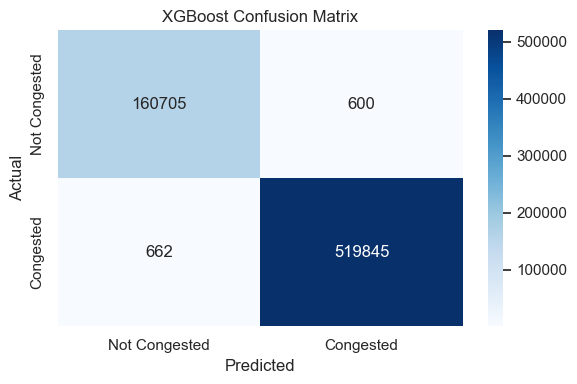

,Score
Accuracy,0.998149
Precision,0.998847
Recall,0.998728
F1 Score,0.998788


In [6]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Identify categorical columns
categorical_features = ['road_functional_hierarchy', 'road_classification_type', 'suburb']

print("Flag 0")
# Step 2: One-hot encode them (drop_first=True to reduce multicollinearity)
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print("Flag 1")

# Step 3: Fit XGBoost model with encoded data
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
print("Flag 2")
model.fit(X_encoded, y)

print("Flag 3")
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

print("Flag 4")
# Ensure columns match (align test to train)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

print("Flag 5")
# Fit the model
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

print("Flag 6")
# Step 3: Evaluate
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Step 4: Format and return results
report_df = pd.DataFrame({
    "Score": [acc, prec, rec, f1]
}, index=["Accuracy", "Precision", "Recall", "F1 Score"])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

report_df


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# --- Assume merged_data is already loaded and cleaned, with column 'congested' defined ---

# 1. Group infrequent suburbs into 'Other'
suburb_counts = merged_data['suburb'].value_counts()
common_suburbs = suburb_counts[suburb_counts > 50].index
merged_data['suburb'] = merged_data['suburb'].apply(lambda x: x if x in common_suburbs else 'Other')

# 2. Add peak-hour aggregates
hour_cols = [f"hour_{i:02d}" for i in range(24)]
merged_data['morning_peak'] = merged_data[[f'hour_{i:02d}' for i in range(7, 10)]].sum(axis=1)
merged_data['evening_peak'] = merged_data[[f'hour_{i:02d}' for i in range(16, 19)]].sum(axis=1)

# 3. Define feature columns
categorical_features = ['road_functional_hierarchy', 'road_classification_type', 'suburb']
numeric_meta = ['traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq',
                'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday',
                'lane_count', 'wgs84_latitude', 'wgs84_longitude', 'morning_peak', 'evening_peak']
feature_cols = numeric_meta + hour_cols + categorical_features

# 4. Remove multicollinear features (threshold 0.95)
corr_matrix = merged_data[feature_cols].corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]
print("Dropping multicollinear features:", to_drop)

feature_cols = [f for f in feature_cols if f not in to_drop]

# 5. Prepare dataset
# One-hot encode categorical variables
X = pd.get_dummies(merged_data[feature_cols], columns=categorical_features, drop_first=True)
y = merged_data['congested']

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 7. Apply SMOTE to balance classes on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 8. Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
grid = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                    param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_
print("Best XGBoost params:", grid.best_params_)

# 9. Evaluate on test set
y_pred = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

# 10. Output results
print("\n--- Classification Report ---")
print(report_df)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("XGBoost Confusion Matrix After Improvements")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


ValueError: could not convert string to float: 'Primary Road'